In [249]:
import torch
import torch.nn as nn
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_wine

In [250]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)

In [251]:
class KANFunction(nn.Module):
    def __init__(self, num_basis=12, input_dim=4, output_dim=3):
        super().__init__()
        self.num_basis = num_basis
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.coeffs = nn.Parameter(torch.randn(num_basis * input_dim, output_dim) * 0.5)
        self.knots = torch.linspace(0, 1, steps=num_basis)

    def forward(self, x):
        x_norm = x
        batch_size = x_norm.shape[0]
        expanded_inputs = []
        for k in self.knots:
            expanded_inputs.append(1 - torch.abs(x_norm - k))
        basis_stack = torch.stack(expanded_inputs, dim=-1)
        basis_stack = basis_stack.view(batch_size, -1)
        return torch.matmul(basis_stack, self.coeffs)

In [252]:
class KANNode(nn.Module):
    def __init__(self, num_basis=12, input_dim=4, output_dim=3, plasticity='LTD', inhibition=False, adaptive=False):
        super().__init__()
        self.kan_func = KANFunction(num_basis, input_dim, output_dim)
        self.plasticity = plasticity
        self.inhibition = inhibition
        self.adaptive = adaptive
        self.activity_trace = 0.0
        self.last_input = None
        self.last_output = None

    def forward(self, x):
        self.last_input = x.detach()
        out = self.kan_func(x)

        #homeostasis
        target_mean_activity = 0.2
        current_mean = out.mean().item()
        self.activity_trace = 0.9 * self.activity_trace + 0.1 * current_mean
        correction = self.activity_trace - target_mean_activity
        out = out - 0.1 * correction

        #inhibición adaptativa
        if self.inhibition:
            inhibition_level = torch.relu(self.last_input).mean().item()
            out = out - 0.1 * inhibition_level

        out = out.view(x.shape[0], -1)
        self.last_output = out.detach()
        return out

    def apply_plasticity(self, error_signal=None):
        with torch.no_grad():
            if self.last_input is None:
                return

            batch_size = self.last_input.shape[0]
            expanded_inputs = []
            for k in self.kan_func.knots:
                expanded_inputs.append(1 - torch.abs(self.last_input - k))
            basis_stack = torch.stack(expanded_inputs, dim=-1)
            basis_stack = basis_stack.view(batch_size, -1)

            expanded_input = basis_stack[0]

            #error local
            predicted = self.kan_func(self.last_input.unsqueeze(0)).squeeze(0)
            if error_signal is not None:
                combined_error = error_signal + (predicted - predicted.detach())
            else:
                combined_error = predicted - predicted.detach()

            update = 0.01 * (expanded_input.view(-1, 1) @ combined_error.view(1, -1))

            if self.plasticity == 'LTD':
                update = -update
            elif self.plasticity == 'LTP':
                update = +update
            elif self.plasticity == 'STDP':
                update = torch.sign(update) * 0.005

            self.kan_func.coeffs.data.copy_(
                torch.clamp(self.kan_func.coeffs.data + update, min=-1.0, max=1.0)
            )


In [253]:
class CerebellarKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cells = nn.ModuleList()

    def add_cell(self, cell):
        self.cells.append(cell)

    def forward(self, x):
        self.intermediate_outputs = []
        for cell in self.cells:
            x = cell(x)
            self.intermediate_outputs.append(x)
        return x

    def apply_plasticity(self, final_error_signal):
        if len(self.cells) > 0:
            last_cell = self.cells[-1]
            last_cell.apply_plasticity(final_error_signal)

In [254]:
def load_dataset(path, input_cols, target_col):
    df = pd.read_excel(path)
    class_mapping = {label: idx for idx, label in enumerate(df[target_col].unique())}
    reverse_mapping = {v: k for k, v in class_mapping.items()}
    df[target_col] = df[target_col].map(class_mapping)
    
    X = df[input_cols].values
    y = df[target_col].values

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    
    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), \
           torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long), reverse_mapping

In [255]:
def train(model, data, targets, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    loss_fn = nn.CrossEntropyLoss()
    entropy_lambda = 0.01

    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0

        for x, y_true in zip(data, targets):
            x = x.unsqueeze(0)
            y_true = y_true.unsqueeze(0)

            y_pred = model(x)
            probs = torch.softmax(y_pred, dim=1)
            entropy = -(probs * torch.log(probs + 1e-8)).sum()
            loss = loss_fn(y_pred, y_true) + entropy_lambda * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            true_one_hot = torch.nn.functional.one_hot(y_true, num_classes=probs.shape[1]).float()
            error_signal = (true_one_hot - probs).squeeze(0).detach()
            model.apply_plasticity(error_signal)

            total_loss += loss.item()
            correct += (y_pred.argmax(dim=1) == y_true).sum().item()

        acc = correct / len(data)
        train_loss.append(total_loss)
        train_accuracy.append(acc)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}: Loss = {total_loss:.4f} | Accuracy = {acc:.4f}")

    return train_loss, train_accuracy

In [256]:
def evaluate(model, data, targets):
    correct = 0
    predictions = []

    with torch.no_grad():
        for x, y_true in zip(data, targets):
            x = x.unsqueeze(0)
            y_pred = model(x)
            pred_class = y_pred.argmax(dim=1).item()
            predictions.append(pred_class)
            correct += (pred_class == y_true.item())

    acc = correct / len(data)
    print(f"\nFinal Accuracy: {acc:.4f}")
    return predictions

In [257]:
def plot_metrics(train_loss, train_accuracy):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, marker='o')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracy, marker='o')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [258]:
def plot_confusion(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_labels[i] for i in range(len(class_labels))])
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusión en Test')
    plt.show()

## DATASET ARM DATA

In [259]:
dataset_path = './utils/armdata.xlsx'
input_columns = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'x', 'y', 'z']
target_column = 'Class'

In [260]:
X_train, X_test, y_train, y_test, reverse_mapping = load_dataset(dataset_path, input_columns, target_column)

In [261]:
model = CerebellarKAN()

In [262]:
model.add_cell(KANNode(num_basis=12, input_dim=X_train.shape[1], output_dim=16, plasticity='STDP', inhibition=True, adaptive=True))
model.add_cell(KANNode(num_basis=12, input_dim=16, output_dim=12, plasticity='STDP', inhibition=False, adaptive=True))
model.add_cell(KANNode(num_basis=12, input_dim=12, output_dim=len(reverse_mapping), plasticity='STDP'))


In [263]:
train_loss, train_accuracy = train(model, X_train, y_train, epochs=100)

Epoch 1: Loss = 927.2371 | Accuracy = 0.3750
Epoch 11: Loss = 118.1836 | Accuracy = 0.7500
Epoch 21: Loss = 41.7027 | Accuracy = 0.9062
Epoch 31: Loss = 38.0840 | Accuracy = 0.8750
Epoch 41: Loss = 12.4434 | Accuracy = 0.9062
Epoch 51: Loss = 9.4946 | Accuracy = 0.9375
Epoch 61: Loss = 39.3339 | Accuracy = 0.8438
Epoch 71: Loss = 14.6982 | Accuracy = 0.8438
Epoch 81: Loss = 23.4790 | Accuracy = 0.8750
Epoch 91: Loss = 43.9701 | Accuracy = 0.7812
Epoch 100: Loss = 24.7407 | Accuracy = 0.8125


In [264]:
print("\nEvaluación en Test:")
preds = evaluate(model, X_test, y_test)


Evaluación en Test:

Final Accuracy: 0.7500


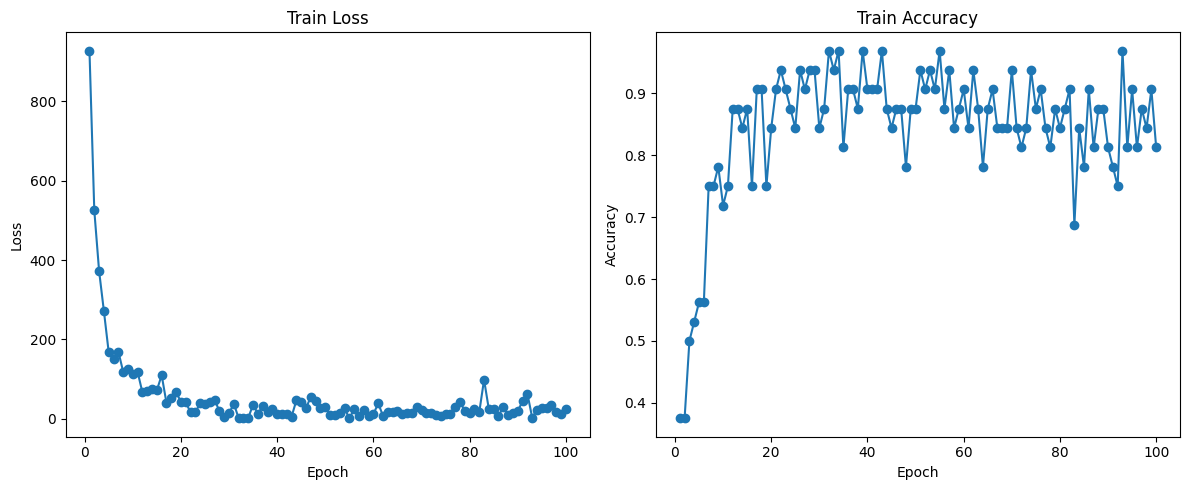

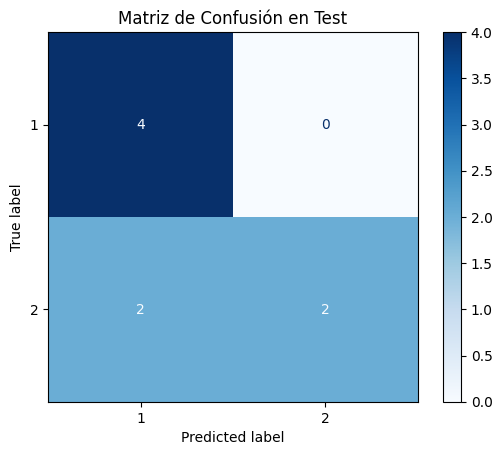

In [265]:
plot_metrics(train_loss, train_accuracy)
plot_confusion(y_test, preds, reverse_mapping)

## DATASET IRIS

In [266]:
dataset_path = './utils/Iris.xlsx'
input_columns = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
target_column = 'Species'

In [267]:
X_train, X_test, y_train, y_test, reverse_mapping = load_dataset(dataset_path, input_columns, target_column)

In [268]:
model = CerebellarKAN()

In [269]:
model.add_cell(KANNode(num_basis=12, input_dim=X_train.shape[1], output_dim=8, plasticity='STDP', inhibition=True, adaptive=True))
model.add_cell(KANNode(num_basis=12, input_dim=8, output_dim=6, plasticity='STDP', inhibition=False, adaptive=True))
model.add_cell(KANNode(num_basis=12, input_dim=6, output_dim=len(reverse_mapping), plasticity='STDP'))

In [270]:
train_loss, train_accuracy = train(model, X_train, y_train, epochs=100)

Epoch 1: Loss = 778.6289 | Accuracy = 0.5083
Epoch 11: Loss = 75.3261 | Accuracy = 0.9333
Epoch 21: Loss = 107.9785 | Accuracy = 0.9000
Epoch 31: Loss = 35.8154 | Accuracy = 0.9667
Epoch 41: Loss = 91.6420 | Accuracy = 0.9500
Epoch 51: Loss = 64.1342 | Accuracy = 0.9583
Epoch 61: Loss = 50.9814 | Accuracy = 0.9583
Epoch 71: Loss = 30.4386 | Accuracy = 0.9667
Epoch 81: Loss = 23.9045 | Accuracy = 0.9667
Epoch 91: Loss = 17.6965 | Accuracy = 0.9833
Epoch 100: Loss = 28.2766 | Accuracy = 0.9500


In [271]:
print("\nEvaluación en Test:")
preds = evaluate(model, X_test, y_test)


Evaluación en Test:

Final Accuracy: 0.9333


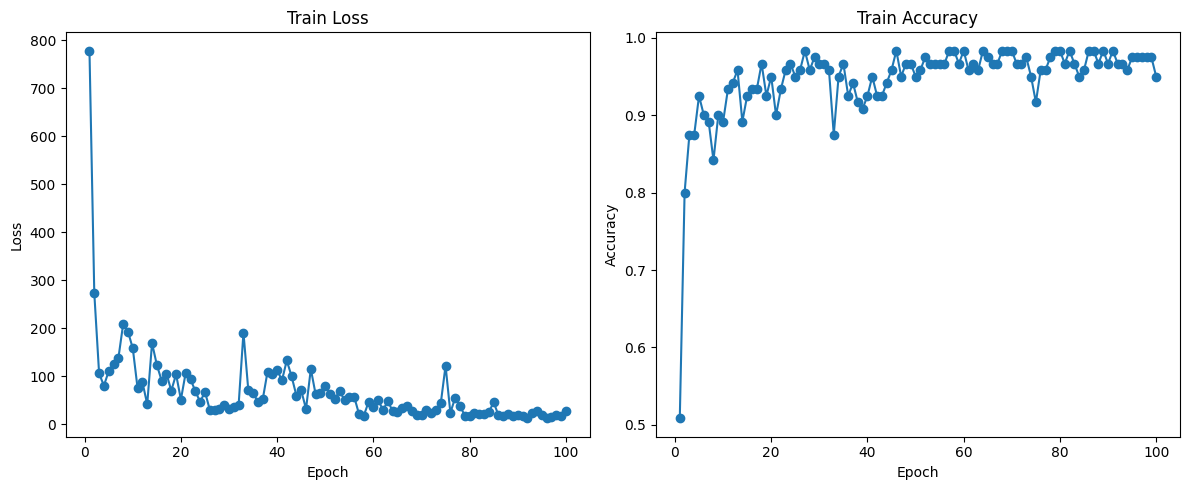

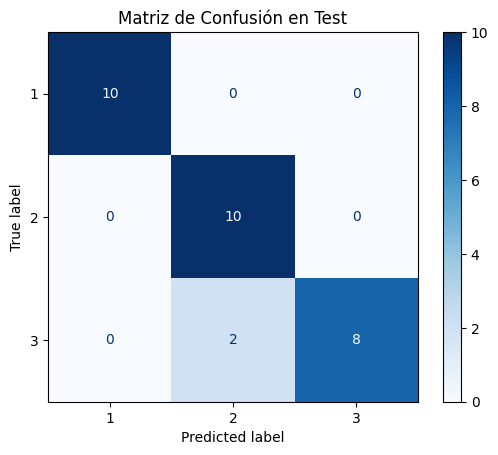

In [272]:
plot_metrics(train_loss, train_accuracy)
plot_confusion(y_test, preds, reverse_mapping)

## DATASET WINE

In [273]:
def load_wine_dataset():
    data = load_wine()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    target_names = data.target_names

    # Normalizar X
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    return (torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long),
            torch.tensor(y_test, dtype=torch.long),
            {i: name for i, name in enumerate(target_names)})


In [274]:
X_train, X_test, y_train, y_test, reverse_mapping = load_wine_dataset()

In [275]:
model = CerebellarKAN()

In [276]:
model.add_cell(KANNode(num_basis=12, input_dim=X_train.shape[1], output_dim=32, plasticity='STDP', inhibition=True, adaptive=True))
model.add_cell(KANNode(num_basis=12, input_dim=32, output_dim=16, plasticity='STDP', inhibition=True))
model.add_cell(KANNode(num_basis=12, input_dim=16, output_dim=len(reverse_mapping), plasticity='STDP'))

In [277]:
train_loss, train_accuracy = train(model, X_train, y_train, epochs=100)

Epoch 1: Loss = 3570.1817 | Accuracy = 0.7113
Epoch 11: Loss = 814.5300 | Accuracy = 0.5141
Epoch 21: Loss = 311.3134 | Accuracy = 0.5986
Epoch 31: Loss = 221.8222 | Accuracy = 0.6831
Epoch 41: Loss = 101.0891 | Accuracy = 0.8521
Epoch 51: Loss = 85.8836 | Accuracy = 0.8662
Epoch 61: Loss = 84.3307 | Accuracy = 0.8380
Epoch 71: Loss = 167.2157 | Accuracy = 0.8099
Epoch 81: Loss = 371.0706 | Accuracy = 0.7324
Epoch 91: Loss = 348.8774 | Accuracy = 0.8099
Epoch 100: Loss = 102.4110 | Accuracy = 0.9014


In [278]:
print("\nEvaluación en Test:")
preds = evaluate(model, X_test, y_test)


Evaluación en Test:

Final Accuracy: 0.7500


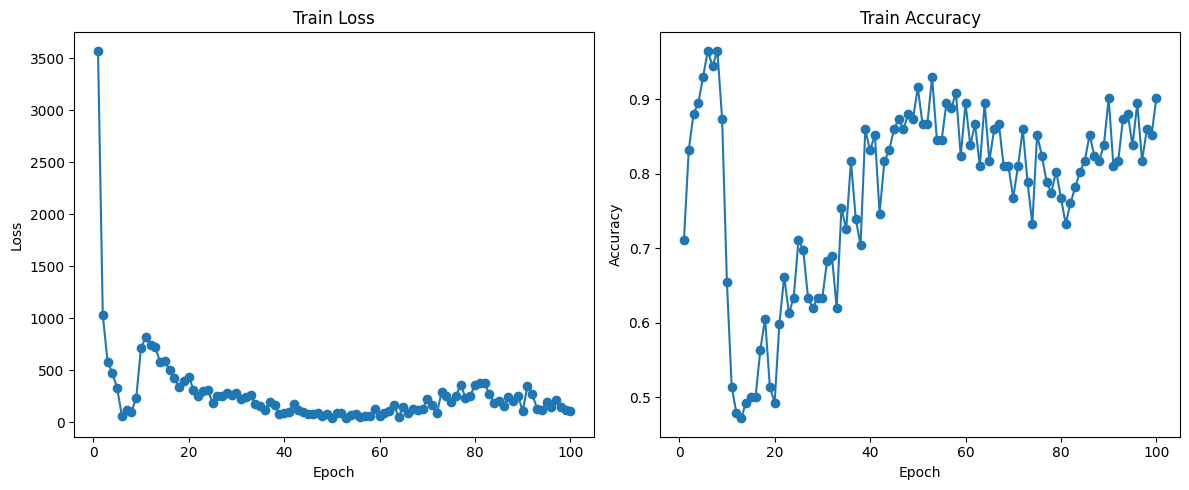

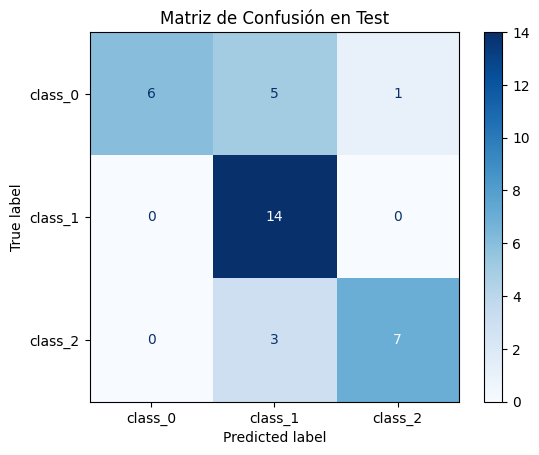

In [279]:
plot_metrics(train_loss, train_accuracy)
plot_confusion(y_test, preds, reverse_mapping)